# Testing Snowplow Algorithm

Consideration: if no unserviced edges except for u-turning, consider probabilistically choosing to traverse a serviced edge to escape a local area.

In [17]:
import os
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import Snowplow_Routing_Middleton.dual_graphs as dual_graphs
import Snowplow_Routing_Middleton.construction as construction
import Snowplow_Routing_Middleton.plotting as plotting
import Snowplow_Routing_Middleton.local_search as local_search
import Snowplow_Routing_Middleton.initialize as initialize
import Snowplow_Routing_Middleton.params as params
import Snowplow_Routing_Middleton.sectioning as sectioning
import Snowplow_Routing_Middleton.costs as costs


from Snowplow_Routing_Middleton.shortest_paths import ShortestPaths
from Snowplow_Routing_Middleton.crossover import apply_crossover
from Snowplow_Routing_Middleton.genetic import run_genetic
from Snowplow_Routing_Middleton.solution import Solution
from Snowplow_Routing_Middleton.costs import routes_cost, calculate_time_deadheading
from Snowplow_Routing_Middleton.routes_representations import create_full_routes_with_returns
from Snowplow_Routing_Middleton.turns import turn_direction_count

import pandas as pd
import osmnx as ox
import folium
import folium.plugins
import networkx as nx
import pickle
import matplotlib.pyplot as plt


Autoreload documentation: https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html

For reloading user modules

In [19]:
toyEdgeFile = "C:\\Users\\Sneez\\Desktop\\Snowplowing\\Snowplow-Routing-Middleton\\Snowplow-Routing-Middleton\\graph_data\\edges.csv"
toyNodeFile = "C:\\Users\\Sneez\\Desktop\\Snowplowing\\Snowplow-Routing-Middleton\\Snowplow-Routing-Middleton\\graph_data\\nodes.csv"

In [20]:
curr_path = os.path.abspath("")
parent_path = os.path.split(curr_path)[0]

In [21]:
instance = "sectionedfullstreets"

polygon_path = os.path.join(parent_path, "graph_data\\individual_sections\\route1_blue.gpkg")

match instance:
    case "smallstreets":
        G = initialize.create_small_streets()
    case "fullstreets":
        G = initialize.create_full_streets()
    case "smalltoy":
        G = initialize.create_small_toy(toyEdgeFile, toyNodeFile)
    case "sectionedfullstreets":
        G = sectioning.section_component(polygon_path, False)
    case _:
        print("Invalid instance name")
     

In [22]:
ox.graph_to_gdfs(G, nodes=False, edges=True).explore()

Update depot

In [23]:
if instance == "fullstreets" or instance == "sectionedfullstreets":
    params.DEPOT = params.find_depot(G)[0]
else:
    params.DEPOT = 0
params.DEPOT

136

In [24]:
approach = "genetic"

if approach == "genetic":
    G = initialize.add_multi_edges(G)
    if instance == "smallstreets" or instance == "fullstreets" or instance == "sectionedfullstreets":
        G_DUAL = dual_graphs.create_dual_streets(G, params.DEPOT)
    else:
        G_DUAL = dual_graphs.create_dual_toy(G)

elif approach == "annealing":
    if instance == "smallstreets" or instance == "fullstreets" or instance == "sectionedfullstreets":
        G_DUAL = dual_graphs.create_dual_streets(G, False, True)
    else:
        G_DUAL = dual_graphs.create_dual_toy(G, False, True)



Adding depot source 136


In [25]:
print(G)
print(G_DUAL)

MultiDiGraph with 170 nodes and 637 edges
MultiDiGraph with 638 nodes and 3521 edges


In [26]:
blue_shortest_paths_folderpath  = os.path.join(parent_path, "graph_data\\shortest_paths\\route1_blue")


In [27]:
sp = ShortestPaths(G_DUAL, True, False, blue_shortest_paths_folderpath)

In [28]:
r, rreq = construction.route_generation(G, sp, params.DEPOT)

Test Local Search

In [29]:
required_edges = set(edge[:3] for edge in G.edges(data=True, keys=True) if edge[3]['priority'] != 0)
S_first = Solution(rreq, dict(), routes_cost(G, sp, rreq, params.DEPOT), 0)

print(S_first.cost)


27826.514148568163


In [30]:
_, head = local_search.individual_to_linked_list(rreq, params.DEPOT)
print("Linked list costs:", costs.routes_cost_linked_list(G, sp, head, params.DEPOT))
print("Normal cost:", routes_cost(G, sp, rreq, params.DEPOT))

Linked list costs: 27826.514148568163
Normal cost: 27826.514148568163


In [31]:
serviced = set()
for route in S_first.routes:
    for edge in route:
        serviced.add(edge[:3])
print(len(serviced), len(required_edges))

563 563


In [32]:
S_new = local_search.local_improve(S_first, G, sp, required_edges, params.DEPOT, threshold=1)
print(routes_cost(G, sp, S_new.routes, params.DEPOT))
for route in S_new.routes:
    for routestep in route:
        print(routestep)
    print("***")

Modifed  29 times
26718.08052095197
(138, 136, 0)
(136, 137, 0)
(137, 138, 1)
(136, 135, 1)
(135, 116, 1)
(116, 68, 1)
(68, 116, 1)
(116, 134, 0)
(134, 116, 0)
(116, 135, 0)
(135, 136, 0)
(137, 139, 0)
(138, 137, 0)
(139, 140, 0)
(140, 141, 0)
(141, 151, 0)
(151, 138, 0)
(138, 137, 1)
(137, 138, 0)
(136, 135, 0)
(135, 116, 0)
(116, 68, 0)
(68, 67, 0)
(67, 115, 0)
(115, 83, 0)
(83, 81, 0)
(81, 79, 0)
(79, 64, 0)
(86, 71, 0)
(71, 32, 0)
(32, 69, 0)
(69, 69, 0)
(69, 32, 0)
(32, 71, 0)
(71, 152, 0)
(152, 22, 0)
(22, 148, 0)
(148, 60, 0)
(60, 61, 0)
(61, 62, 0)
(62, 63, 0)
(63, 84, 0)
(84, 81, 2)
(81, 78, 1)
(78, 81, 1)
(81, 84, 1)
(84, 81, 0)
(81, 78, 2)
(78, 81, 2)
(81, 84, 2)
(84, 81, 1)
(79, 77, 0)
(77, 79, 0)
(79, 63, 0)
(63, 85, 0)
(85, 63, 0)
(63, 79, 0)
(79, 77, 1)
(77, 79, 1)
(79, 63, 1)
(63, 85, 1)
(85, 63, 1)
(63, 79, 1)
(79, 77, 2)
(77, 79, 2)
(79, 63, 2)
(63, 85, 2)
(85, 63, 2)
(63, 79, 2)
(86, 152, 0)
(148, 61, 0)
(62, 64, 0)
(71, 32, 1)
(32, 69, 1)
(69, 32, 1)
(32, 71, 1)
(71

{'straight': 367, 'u-turn': 123, 'left': 60, 'sharp left': 47, 'right': 137, 'sharp right': 49}


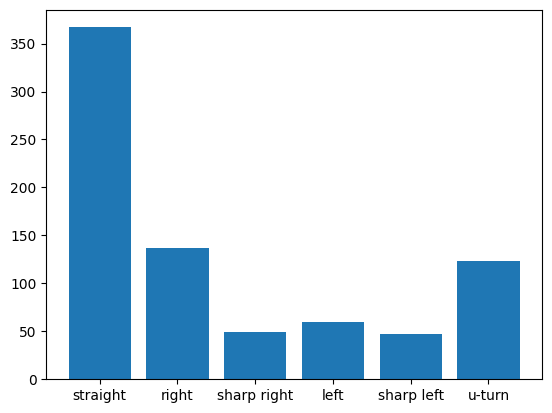

In [33]:
full_routes = create_full_routes_with_returns(G, sp, rreq, params.DEPOT)
counts, x_axis, y_axis = turn_direction_count(G_DUAL, full_routes)
print(counts)
plt.bar(x_axis, y_axis)
plotting.plot_moving_routes_folium(G, full_routes, label_color="blue", path_color="blue", m=None)

In [34]:
s1, s1req = construction.route_generation(G, sp, params.DEPOT)
S1 = Solution(s1req, dict(), routes_cost(G, sp, s1req, params.DEPOT), 0)
S1 = local_search.local_improve(S1, G, sp, required_edges, params.DEPOT, threshold=1)

s2, s2req = construction.route_generation(G, sp, params.DEPOT)
S2 = Solution(s2req, dict(), routes_cost(G, sp, s2req, params.DEPOT), 0)
S2 = local_search.local_improve(S2, G, sp, required_edges, params.DEPOT, threshold=1)

C:\Users\Sneez\Desktop\Snowplowing\Snowplow_Routing_Middleton\Snowplow_Routing_Middleton\construction.py:290: RuntimeWarning: invalid value encountered in divide
  weights_turns = weights_turns / np.sum(weights_turns)


Modifed  23 times
Modifed  15 times


In [35]:
S0 = apply_crossover(G, sp, S1.routes, S2.routes, params.DEPOT)
# idea for crossover: don't crossover a whole subsection of routes, but rather a fixed chunk (say 20-30 routesteps) of a route. This would significantly improve computation speed

In [36]:
count0, count1, count2 = 0, 0, 0
for route in S0:
    for routestep in route:
        count0 += 1
for route in S1.routes:
    for routestep in route:
        count1 += 1
for route in S2.routes:
    for routestep in route:
        count2 += 1


print(count0, count1, count2)

563 563 563


In [37]:
# 4. Route Improvement Algorithms
sol = run_genetic(G, sp, params.DEPOT)

for route in sol.routes:
    for edge in route:
        print(edge)
    print("***")

initial generation 0
Modifed  24 times
initial generation 1
Modifed  25 times
initial generation 2
Modifed  24 times
initial generation 3
Modifed  35 times
initial generation 4
Modifed  22 times
initial generation 5
Modifed  18 times
initial generation 6
Modifed  20 times
initial generation 7
Modifed  40 times
initial generation 8
Modifed  40 times
initial generation 9
Modifed  20 times
Iteration 0
Modifed  9 times
Iteration 1
Modifed  4 times
Iteration 2
Modifed  4 times
Iteration 3
Modifed  4 times
Iteration 4
Modifed  6 times
Iteration 5
Modifed  3 times
Iteration 6
Modifed  4 times
Iteration 7
Modifed  6 times
New best solution found
Iteration 8
Modifed  5 times
Iteration 9
Modifed  1 times
Iteration 10
Modifed  3 times
Iteration 11
Modifed  2 times
Iteration 12
Modifed  7 times
Iteration 13
Modifed  0 times
Iteration 14
Modifed  3 times
Iteration 15
Modifed  1 times
Iteration 16
Modifed  0 times
Iteration 17
Modifed  0 times
Iteration 18
Modifed  0 times
Iteration 19
Modifed  2 ti

In [71]:
first_full_route = create_full_routes_with_returns(G, sp, rreq, params.DEPOT)
time_seconds_first = costs.route_travel_time(G, first_full_route, params.DEPOT)
print("First route cost", routes_cost(G, sp, rreq, params.DEPOT))
print("First route travel time hours", time_seconds_first/3600)
print("First route deadhead time hours", calculate_time_deadheading(rreq, sp, params.DEPOT)/3600)

First route cost 33628.65268563319
First route travel time hours 7.004569196573838
First route deadhead time hours 1.779240086192093


In [72]:
final_full_route = create_full_routes_with_returns(G, sp, sol.routes, params.DEPOT)
time_seconds = costs.route_travel_time(G, final_full_route, params.DEPOT)
# Display costs and travel time
print("Final Routes cost", sol.cost)
print("Final Travel time hours", time_seconds/3600)
print("Final Deadhead time hours", calculate_time_deadheading(sol.routes, sp, params.DEPOT)/3600)

Final Routes cost 31170.18627534145
Final Travel time hours 6.629826689971492
Final Deadhead time hours 1.3129650963373898


In [75]:
plotting.plot_moving_routes_folium(G, final_full_route, label_color="blue", path_color="blue", m=None)